In [1]:
print("Loading required libraries...")


import numpy as np
import random
import math

# For loading and displaying images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

# OpenCV for image manipulation
import cv2

# Pandas for loading csv files and dataframes
import pandas as pd

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# For Keras
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D

print("Libraries loaded")


Loading required libraries...


Using TensorFlow backend.


Libraries loaded


### Get Data

In [2]:
import os
import platform

In [3]:
os_type = platform.system()
print(os_type)

joiner = '/'

if os_type == 'Windows':
    joiner = '\\'

path = os.getcwd()
print(path)


data_path = path + joiner + r'data' + joiner
data_log_path = data_path + r'driving_log.csv'
images_path = data_path + r'IMG'


print(data_log_path,images_path)

Linux
/home/carnd/P3/behaviour-cloning
/home/carnd/P3/behaviour-cloning/data/driving_log.csv /home/carnd/P3/behaviour-cloning/data/IMG


In [4]:
data_log = pd.read_csv(data_log_path)

print(data_log.describe())

          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


(array([  6.00000000e+00,   7.00000000e+00,   1.01000000e+02,
          3.94000000e+02,   5.76700000e+03,   1.40500000e+03,
          3.04000000e+02,   4.40000000e+01,   6.00000000e+00,
          2.00000000e+00]),
 array([-0.9426954 , -0.74842586, -0.55415632, -0.35988678, -0.16561724,
         0.0286523 ,  0.22292184,  0.41719138,  0.61146092,  0.80573046,  1.        ]),
 <a list of 10 Patch objects>)

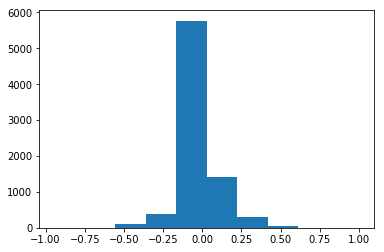

In [5]:
plt.hist(data_log['steering'])

In [6]:
''' 
This function generates paths for left, center and right cameras images

Arguments: 
Takes 3 arguments
path: where data is stored
data: data_log's panda variable
row_num: number of row we are selecting

Outputs:
A tuple with 3 paths for left, center and right camera images respectively
'''
def get_image_paths(path,data,row_num):
    l_img_path = path + data.iloc[row_num]['left'].strip()
    c_img_path = path + data.iloc[row_num]['center'].strip()
    r_img_path = path + data.iloc[row_num]['right'].strip()
    
    return (l_img_path,c_img_path,r_img_path)

Left image path = /home/carnd/P3/behaviour-cloning/data/IMG/left_2016_12_01_13_30_48_287.jpg
center image path = /home/carnd/P3/behaviour-cloning/data/IMG/center_2016_12_01_13_30_48_287.jpg
right image path = /home/carnd/P3/behaviour-cloning/data/IMG/right_2016_12_01_13_30_48_287.jpg


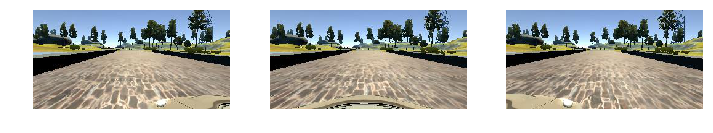

In [7]:
images_path = get_image_paths(data_path,data_log,0)

print("Left image path = "+ images_path[0])
print("center image path = "+ images_path[1])
print("right image path = " + images_path[2])

gs1 = gridspec.GridSpec(1,3)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(3):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = mpimg.imread(images_path[i])
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [8]:
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(160, 320, 3)


### Pre-processing and Image generator

In [9]:
new_height,new_width,channels = 66,200,3 #global variables

In [25]:
def get_img(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def get_resized_img(img):
    img = cv2.resize(img,(new_width,new_height),interpolation=cv2.INTER_AREA)
    return img

def crop_img(img):
    height = img.shape[0]
    width = img.shape[1]
    top = math.floor(height/5)
    bottom = height - 25
    img = img[top:bottom]
    return img


def preprocess_images(row_data,validation = False):
    # Get paths
    selector = np.random.randint(3)
    
    # zero for left
    if selector == 0:
        img_path = data_path + row_data.iloc[0]['left'].strip()
        shift_ang = .25
        
    # one for center
    elif selector == 1:
        img_path = data_path + row_data.iloc[0]['center'].strip()
        shift_ang = 0.
        
    # two for right
    else:
        img_path = data_path + row_data.iloc[0]['right'].strip()
        shift_ang = -.25
    
    img = get_img(img_path)
    img = crop_img(img)
    img = get_resized_img(img)
    
    steering = row_data.iloc[0]['steering']
    #print(steering)
    
    steering = steering + shift_ang
    
    if validation:
        return img,steering
    
    return img,steering

In [11]:
def image_generator(data,batch_size=32,validation=False):
    length_of_data = len(data)
    
    # Create empty numpy array batches for images and steering
    batch_images = np.zeros((batch_size,new_height,new_width,channels))
    batch_steering = np.zeros(batch_size)
    
    while True:
        for i in range(batch_size):
            # Randomly select one of the capured images from data_log
            selector = np.random.randint(length_of_data)
            row_data = data.iloc[[selector]]
            
            # Pre-process the image differently for training and validation image generators
            x,y = preprocess_images(row_data,validation)
            
            batch_images[i] = x 
            batch_steering[i] = y
        yield batch_images,batch_steering
            

In [26]:
image6,_ = preprocess_images(data_log.iloc[[1]])
print(type(image6))
print(image6.shape)

<class 'numpy.ndarray'>
(66, 200, 3)


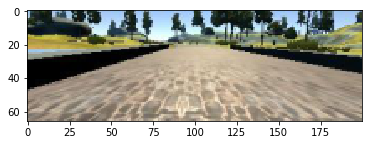

In [27]:
plt.imshow(image6)

#### Test image genrator

In [14]:
to_test_gen = image_generator(data_log,3,validation=True)


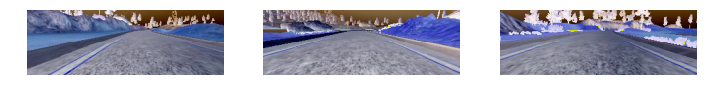

In [28]:
count = 0
for x,y in to_test_gen:
    length = len(x)
    gs1 = gridspec.GridSpec(1,length)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
    plt.figure(figsize=(12,12))
    for j in range(length):
        ax1 = plt.subplot(gs1[j])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        img = x[j]
        plt.subplot(1,length,j+1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()
    count +=1
    if count>0:
        break

### Define Model

In [16]:
def nvidia_model():
    ch, row, col = 3, 66, 200  # camera format
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(row, col,ch),output_shape=(row, col,ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

### Sanity check

[ 0.3679529  0.        -0.2781274]


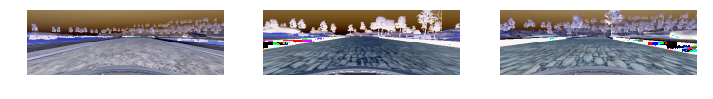

In [17]:
sanity_batch_data2 = np.zeros((3,66,200,3))
sanity_batch_steering = np.zeros(3)

sanity_batch_data2[0] = get_resized_img(get_img(data_path+data_log.iloc[54]['center'].strip()))
sanity_batch_data2[1] = get_resized_img(get_img(data_path+data_log.iloc[0]['center'].strip()))
sanity_batch_data2[2] = get_resized_img(get_img(data_path+data_log.iloc[154]['center'].strip()))

sanity_batch_steering[0] = data_log.iloc[54]['steering']
sanity_batch_steering[1] = data_log.iloc[0]['steering']
sanity_batch_steering[2] = data_log.iloc[154]['steering']

print(sanity_batch_steering)

gs1 = gridspec.GridSpec(1,3)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(3):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = sanity_batch_data2[i]
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

#### Intialize model

In [18]:
model = nvidia_model()

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       activation_1[0][0]               
___________________________________________________________________________________________

#### Train on sanity data

In [19]:
model.fit(sanity_batch_data2,sanity_batch_steering,nb_epoch=20)

Epoch 1/20
3/3 [==============================] - 3s - loss: 0.0704
Epoch 2/20
3/3 [==============================] - 0s - loss: 0.0571
Epoch 3/20
3/3 [==============================] - 0s - loss: 0.0429
Epoch 4/20
3/3 [==============================] - 0s - loss: 0.0180
Epoch 5/20
3/3 [==============================] - 0s - loss: 0.0060
Epoch 6/20
3/3 [==============================] - 0s - loss: 0.0237
Epoch 7/20
3/3 [==============================] - 0s - loss: 0.0028
Epoch 8/20
3/3 [==============================] - 0s - loss: 0.0051
Epoch 9/20
3/3 [==============================] - 0s - loss: 0.0061
Epoch 10/20
3/3 [==============================] - 0s - loss: 0.0040
Epoch 11/20
3/3 [==============================] - 0s - loss: 9.1181e-04
Epoch 12/20
3/3 [==============================] - 0s - loss: 6.4025e-04
Epoch 13/20
3/3 [==============================] - 0s - loss: 0.0011
Epoch 14/20
3/3 [==============================] - 0s - loss: 3.6688e-04
Epoch 15/20
3/3 [==============

#### Test on same sanity data

In [20]:
model.evaluate(sanity_batch_data2,sanity_batch_steering)
model.predict(sanity_batch_data2)

3/3 [==============================] - 0s


array([[ 0.37087202],
       [ 0.00612422],
       [-0.27071014]], dtype=float32)

### Dude do real training

In [21]:
training_generator = image_generator(data_log,128)
validation_generator = image_generator(data_log,128)

model2 = nvidia_model()

In [ ]:
history = model2.fit_generator(training_generator,samples_per_epoch=8000,nb_epoch=5,validation_data=validation_generator,nb_val_samples=500)

Epoch 1/5
7936/8000 [============================>.] - ETA: 0s - loss: 0.0269

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


8064/8000 [==============================] - 23s - loss: 0.0269 - val_loss: 0.0238
Epoch 2/5
8064/8000 [==============================] - 20s - loss: 0.0221 - val_loss: 0.0195
Epoch 3/5
8064/8000 [==============================] - 20s - loss: 0.0209 - val_loss: 0.0196
Epoch 4/5
 896/8000 [==>...........................] - ETA: 6s - loss: 0.0173

### Save model 
As json and it's weight as hdfs5 format

In [198]:
 '''
    if not os.path.exists("./outputs"):
        os.makedirs("./outputs")
'''

In [23]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [24]:
model.save_weights("model.h5")

In [197]:
'''

model.fit_generator(
    image_generator(data_log,2),
    samples_per_epoch=10,
    nb_epoch=10,
  )

json_string = model.to_json()

def get_paths_angle(row_data):
    l_img_path = data_path + row_data.iloc[0]['left'].strip()
    c_img_path = data_path + row_data.iloc[0]['center'].strip()
    r_img_path = data_path + row_data.iloc[0]['right'].strip()
    angle = row_data.iloc[0]['steering']
    
    return (l_img_path,c_img_path,r_img_path,angle)


'''

'\n\nmodel.fit_generator(\n    image_generator(data_log,2),\n    samples_per_epoch=10,\n    nb_epoch=10,\n  )\n\njson_string = model.to_json()\n'

In [231]:
def kkk(x):
    k = 0
    c='remo'
    while True:
        if k > x:
            return
        else:
            yield k,c
            k = k+1

ddd = kkk(20)
            
for z,ff in ddd:
    print(ff)

remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
